In [ ]:
#a fresh Python environment
!pip install --force-reinstall --no-cache-dir numpy==1.24.3 scipy==1.10.1 gensim==4.3.0

In [18]:


print("✓ Installation complete!")
print("\nInstalled packages:")
print("- gensim (Word2Vec, GloVe, FastText)")
print("\nLet us compare all the text to vector or embedding models.")

✓ Installation complete!

Installed packages:
- gensim (Word2Vec, GloVe, FastText)

You can now run the embedding comparison code.


 IMPORTS & SETUP

In [2]:
import re, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [3]:
CSV_PATH = "/kaggle/input/reviews/reviews.csv"
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print("Loading data...")
df = pd.read_csv(CSV_PATH).dropna(subset=["Text"]).reset_index(drop=True)
X_all = df["Text"].astype(str).tolist()
y_all = df["Sentiment"].astype(int).to_numpy()

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=SEED, stratify=y_all
)
print(f"✓ {len(X_train_text)} train | {len(X_test_text)} test\n")

Loading data...
✓ 40000 train | 10000 test



In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x)).squeeze(1)
        return x

In [6]:
def train_model(X_train, X_test, y_train, y_test):
    """Train and evaluate model"""
    # Convert to tensors
    X_tr = torch.tensor(X_train, dtype=torch.float32)
    X_te = torch.tensor(X_test, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    y_te = torch.tensor(y_test, dtype=torch.float32)
    
    # Setup model
    model = SimpleNN(X_train.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCELoss()
    
    # Training
    train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=64, shuffle=True)
    model.train()
    for epoch in range(6):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_te.to(device)).cpu().numpy()
    y_pred = (predictions > 0.5).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return acc, f1

In [7]:
print("=" * 60)
print("METHOD 1: COUNT VECTORIZER")
print("=" * 60)

vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,1))
X_train_counts = vectorizer.fit_transform(X_train_text)
X_test_counts = vectorizer.transform(X_test_text)

# Reduce dimensions with SVD
svd = TruncatedSVD(n_components=300, random_state=SEED)
X_train_svd = svd.fit_transform(X_train_counts)
X_test_svd = svd.transform(X_test_counts)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svd).astype(np.float32)
X_test_scaled = scaler.transform(X_test_svd).astype(np.float32)

acc, f1 = train_model(X_train_scaled, X_test_scaled, y_train, y_test)
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}\n")

METHOD 1: COUNT VECTORIZER
Accuracy: 0.8566 | F1: 0.8571



In [10]:
print("=" * 60)
print("METHOD 2: TF-IDF")
print("=" * 60)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# Reduce dimensions with SVD
svd = TruncatedSVD(n_components=300, random_state=SEED)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svd).astype(np.float32)
X_test_scaled = scaler.transform(X_test_svd).astype(np.float32)

acc, f1 = train_model(X_train_scaled, X_test_scaled, y_train, y_test)
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}\n")

METHOD 2: TF-IDF
Accuracy: 0.8782 | F1: 0.8786



In [14]:
print("=" * 60)
print("METHOD 3: WORD2VEC (trained on your data)")
print("=" * 60)

from gensim.models import Word2Vec

def tokenize(text):
    """Simple tokenizer"""
    return re.findall(r"[a-z']+", text.lower())

# Train Word2Vec on training data
tokenized_train = [tokenize(text) for text in X_train_text]
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=300, window=5, 
                     min_count=2, sg=1, epochs=10, workers=4)

def document_vector(text, model):
    """Average word vectors for a document"""
    tokens = tokenize(text)
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)

X_train_w2v = np.vstack([document_vector(text, w2v_model) for text in X_train_text]).astype(np.float32)
X_test_w2v = np.vstack([document_vector(text, w2v_model) for text in X_test_text]).astype(np.float32)

acc, f1 = train_model(X_train_w2v, X_test_w2v, y_train, y_test)
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}\n")

METHOD 3: WORD2VEC (trained on your data)
Accuracy: 0.8771 | F1: 0.8796



In [15]:
print("=" * 60)
print("METHOD 4: GLOVE (pretrained embeddings)")
print("=" * 60)

import gensim.downloader as api

print("Downloading GloVe model (this may take a minute)...")
glove_model = api.load("glove-wiki-gigaword-100")

def document_vector_glove(text, model):
    """Average GloVe vectors for a document"""
    tokens = tokenize(text)
    vectors = [model[word] for word in tokens if word in model]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)

X_train_glove = np.vstack([document_vector_glove(text, glove_model) for text in X_train_text]).astype(np.float32)
X_test_glove = np.vstack([document_vector_glove(text, glove_model) for text in X_test_text]).astype(np.float32)

acc, f1 = train_model(X_train_glove, X_test_glove, y_train, y_test)
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}\n")

METHOD 4: GLOVE (pretrained embeddings)
Accuracy: 0.7896 | F1: 0.7990



In [16]:
print("=" * 60)
print("METHOD 5: FASTTEXT (pretrained embeddings)")
print("=" * 60)

print("Downloading FastText model (this may take a few minutes)...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

def document_vector_fasttext(text, model):
    """Average FastText vectors for a document"""
    tokens = tokenize(text)
    vectors = [model[word] for word in tokens if word in model]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)

X_train_ft = np.vstack([document_vector_fasttext(text, fasttext_model) for text in X_train_text]).astype(np.float32)
X_test_ft = np.vstack([document_vector_fasttext(text, fasttext_model) for text in X_test_text]).astype(np.float32)

acc, f1 = train_model(X_train_ft, X_test_ft, y_train, y_test)
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f}\n")

METHOD 5: FASTTEXT (pretrained embeddings)
Accuracy: 0.8440 | F1: 0.8404



In [17]:
print("=" * 60)
print("SUMMARY OF RESULTS")
print("=" * 60)
print("\nAll methods tested with same simple architecture:")
print("- 1 hidden layer (128 neurons)")
print("- 0.3 dropout")
print("- 6 epochs")
print("- Learning rate: 0.001")
print("\nCheck the accuracy & F1 scores above to see which embedding works best!")
print("\nNext step: Take the best embedding and try different architectures.")

SUMMARY OF RESULTS

All methods tested with same simple architecture:
- 1 hidden layer (128 neurons)
- 0.3 dropout
- 6 epochs
- Learning rate: 0.001

Check the accuracy & F1 scores above to see which embedding works best!

Next step: Take the best embedding and try different architectures.


In [23]:
# ============================================================================
# NEURAL NETWORK IMPROVEMENT EXPERIMENTS - SIMPLIFIED VERSION

# ============================================================================
# DEFINE ARCHITECTURES
# ============================================================================
import time
class BaselineNN(nn.Module):
    """
    BASELINE MODEL
    - 1 hidden layer (128 neurons)
    - Simple dropout
    - Total parameters: ~40K
    """
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return torch.sigmoid(self.fc2(x)).squeeze(1)


class DeeperNN(nn.Module):
    """
    EXPERIMENT 1: DEEPER NETWORK
    - 3 hidden layers (256 -> 128 -> 64)
    - Batch normalization added
    - Total parameters: ~110K
    
    HYPOTHESIS: More layers = better feature learning
    """
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        return torch.sigmoid(self.fc4(x)).squeeze(1)


class WiderNN(nn.Module):
    """
    EXPERIMENT 2: WIDER NETWORK
    - 2 hidden layers (512 -> 256)
    - More neurons per layer
    - Total parameters: ~290K
    
    HYPOTHESIS: More neurons = more capacity to learn complex patterns
    """
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        return torch.sigmoid(self.fc3(x)).squeeze(1)


# ============================================================================
# TRAINING FUNCTION
# ============================================================================
def train_model(X_train, X_test, y_train, y_test, 
                model_class, epochs, lr, batch_size, name):
    """Train and evaluate a model"""
    
    print(f"\n{'='*80}")
    print(f"{name}")
    print(f"{'='*80}")
    print(f"Hyperparameters:")
    print(f"  - Epochs: {epochs}")
    print(f"  - Learning Rate: {lr}")
    print(f"  - Batch Size: {batch_size}")
    
    start_time = time.time()
    
    # Prepare data
    X_tr = torch.tensor(X_train, dtype=torch.float32)
    X_te = torch.tensor(X_test, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    y_te = torch.tensor(y_test, dtype=torch.float32)
    
    # Initialize model
    model = model_class(X_train.shape[1]).to(device)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"  - Parameters: {num_params:,}")
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()
    train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
    
    # Training loop
    print(f"\nTraining...")
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        # Print progress
        if epoch == 0 or (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1:2d}/{epochs} - Loss: {avg_loss:.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_te.to(device)).cpu().numpy()
    y_pred = (predictions > 0.5).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    training_time = time.time() - start_time
    
    print(f"\n{'Results:'}")
    print(f"  ✓ Accuracy: {acc:.4f}")
    print(f"  ✓ F1 Score: {f1:.4f}")
    print(f"  ✓ Training Time: {training_time:.2f}s")
    
    return {
        'accuracy': acc,
        'f1': f1,
        'time': training_time,
        'losses': losses,
        'params': num_params,
        'name': name
    }


#

In [39]:
# ============================================================================
# RUN THE 3 EXPERIMENTS
# ============================================================================
print("\n" + "="*80)
print("RUNNING EXPERIMENTS")
print("="*80)

results = []

# BASELINE
results.append(train_model(
    X_train_w2v, X_test_w2v, y_train, y_test,
    model_class=BaselineNN,
    epochs=10,
    lr=0.001,
    batch_size=64,
    name="BASELINE: Simple Network (1 layer, 128 neurons)"
))

# EXPERIMENT 1: Deeper Network
results.append(train_model(
    X_train_w2v, X_test_w2v, y_train, y_test,
    model_class=DeeperNN,
    epochs=10,
    lr=0.001,
    batch_size=64,
    name="EXPERIMENT 1: Deeper Network (3 layers: 256→128→64)"
))

# EXPERIMENT 2: Wider Network
results.append(train_model(
    X_train_w2v, X_test_w2v, y_train, y_test,
    model_class=WiderNN,
    epochs=10,
    lr=0.001,
    batch_size=64,
    name="EXPERIMENT 2: Wider Network (2 layers: 512→256)"
))

# EXPERIMENT 3: Optimized Hyperparameters (using deeper network)
results.append(train_model(
    X_train_w2v, X_test_w2v, y_train, y_test,
    model_class=DeeperNN,
    epochs=10,  # More epochs
    lr=0.0005,  # Lower learning rate
    batch_size=64,
    name="EXPERIMENT 3: Deeper Network + Optimized Hyperparameters (20 epochs, LR=0.0005)"
))





RUNNING EXPERIMENTS

BASELINE: Simple Network (1 layer, 128 neurons)
Hyperparameters:
  - Epochs: 10
  - Learning Rate: 0.001
  - Batch Size: 64
  - Parameters: 38,657

Training...
  Epoch  1/10 - Loss: 0.4591
  Epoch  5/10 - Loss: 0.3013
  Epoch 10/10 - Loss: 0.2883

Results:
  ✓ Accuracy: 0.8803
  ✓ F1 Score: 0.8775
  ✓ Training Time: 13.03s

EXPERIMENT 1: Deeper Network (3 layers: 256→128→64)
Hyperparameters:
  - Epochs: 10
  - Learning Rate: 0.001
  - Batch Size: 64
  - Parameters: 119,169

Training...
  Epoch  1/10 - Loss: 0.3206
  Epoch  5/10 - Loss: 0.2532
  Epoch 10/10 - Loss: 0.2185

Results:
  ✓ Accuracy: 0.8907
  ✓ F1 Score: 0.8938
  ✓ Training Time: 20.08s

EXPERIMENT 2: Wider Network (2 layers: 512→256)
Hyperparameters:
  - Epochs: 10
  - Learning Rate: 0.001
  - Batch Size: 64
  - Parameters: 287,233

Training...
  Epoch  1/10 - Loss: 0.3129
  Epoch  5/10 - Loss: 0.2523
  Epoch 10/10 - Loss: 0.2119

Results:
  ✓ Accuracy: 0.8820
  ✓ F1 Score: 0.8767
  ✓ Training Time: 17

In [40]:
# EXPERIMENT 4: Optimized Hyperparameters (using deeper network)
results.append(train_model(
    X_train_w2v, X_test_w2v, y_train, y_test,
    model_class=DeeperNN,
    epochs=100,  # More epochs
    lr=0.001,  # Lower learning rate
    batch_size=64,
    name="EXPERIMENT 3: Deeper Network + Optimized Hyperparameters (20 epochs, LR=0.0005)"
))



EXPERIMENT 3: Deeper Network + Optimized Hyperparameters (20 epochs, LR=0.0005)
Hyperparameters:
  - Epochs: 100
  - Learning Rate: 0.001
  - Batch Size: 64
  - Parameters: 119,169

Training...
  Epoch  1/100 - Loss: 0.3218
  Epoch  5/100 - Loss: 0.2553
  Epoch 10/100 - Loss: 0.2212
  Epoch 15/100 - Loss: 0.1835
  Epoch 20/100 - Loss: 0.1575
  Epoch 25/100 - Loss: 0.1387
  Epoch 30/100 - Loss: 0.1212
  Epoch 35/100 - Loss: 0.1104
  Epoch 40/100 - Loss: 0.1025
  Epoch 45/100 - Loss: 0.0903
  Epoch 50/100 - Loss: 0.0868
  Epoch 55/100 - Loss: 0.0842
  Epoch 60/100 - Loss: 0.0753
  Epoch 65/100 - Loss: 0.0727
  Epoch 70/100 - Loss: 0.0695
  Epoch 75/100 - Loss: 0.0678
  Epoch 80/100 - Loss: 0.0670
  Epoch 85/100 - Loss: 0.0635
  Epoch 90/100 - Loss: 0.0590
  Epoch 95/100 - Loss: 0.0589
  Epoch 100/100 - Loss: 0.0544

Results:
  ✓ Accuracy: 0.8802
  ✓ F1 Score: 0.8774
  ✓ Training Time: 200.99s


In [43]:
# experiment 5
results.append(train_model(
    X_train_w2v, X_test_w2v, y_train, y_test,
    model_class=BaselineNN,
    epochs=100,
    lr=0.001,
    batch_size=128,
    name="BASELINE: Simple Network (1 layer, 128 neurons)"
))


BASELINE: Simple Network (1 layer, 128 neurons)
Hyperparameters:
  - Epochs: 100
  - Learning Rate: 0.001
  - Batch Size: 128
  - Parameters: 38,657

Training...
  Epoch  1/100 - Loss: 0.5206
  Epoch  5/100 - Loss: 0.3079
  Epoch 10/100 - Loss: 0.2938
  Epoch 15/100 - Loss: 0.2879
  Epoch 20/100 - Loss: 0.2841
  Epoch 25/100 - Loss: 0.2795
  Epoch 30/100 - Loss: 0.2770
  Epoch 35/100 - Loss: 0.2749
  Epoch 40/100 - Loss: 0.2733
  Epoch 45/100 - Loss: 0.2696
  Epoch 50/100 - Loss: 0.2678
  Epoch 55/100 - Loss: 0.2662
  Epoch 60/100 - Loss: 0.2659
  Epoch 65/100 - Loss: 0.2638
  Epoch 70/100 - Loss: 0.2624
  Epoch 75/100 - Loss: 0.2607
  Epoch 80/100 - Loss: 0.2588
  Epoch 85/100 - Loss: 0.2553
  Epoch 90/100 - Loss: 0.2559
  Epoch 95/100 - Loss: 0.2558
  Epoch 100/100 - Loss: 0.2535

Results:
  ✓ Accuracy: 0.8900
  ✓ F1 Score: 0.8910
  ✓ Training Time: 80.82s


In [31]:
# ============================================================================
# RESULTS SUMMARY
# ============================================================================
print("\n\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

# Create comparison table
print("\n{:<60} {:>10} {:>10} {:>12} {:>10}".format(
    "Experiment", "Accuracy", "F1 Score", "Parameters", "Time (s)"
))
print("-" * 104)

for i, r in enumerate(results):
    exp_name = "BASELINE" if i == 0 else f"EXP {i}"
    print("{:<60} {:>10.4f} {:>10.4f} {:>12,} {:>10.1f}".format(
        exp_name, r['accuracy'], r['f1'], r['params'], r['time']
    ))

# Calculate improvements
print("\n" + "="*80)
print("IMPROVEMENTS OVER BASELINE")
print("="*80)

baseline = results[0]
for i in range(1, len(results)):
    r = results[i]
    acc_imp = ((r['accuracy'] - baseline['accuracy']) / baseline['accuracy']) * 100
    f1_imp = ((r['f1'] - baseline['f1']) / baseline['f1']) * 100
    
    print(f"\nEXPERIMENT {i}:")
    print(f"  Accuracy: {acc_imp:+.2f}% {'✓' if acc_imp > 0 else '✗'}")
    print(f"  F1 Score: {f1_imp:+.2f}% {'✓' if f1_imp > 0 else '✗'}")
    print(f"  Extra Time: +{r['time'] - baseline['time']:.1f}s")

# Find best model
best = max(results, key=lambda x: x['f1'])
best_idx = results.index(best)
print(f"\n🏆 BEST MODEL: {'BASELINE' if best_idx == 0 else f'EXPERIMENT {best_idx}'}")
print(f"   Accuracy: {best['accuracy']:.4f}")
print(f"   F1 Score: {best['f1']:.4f}")




FINAL RESULTS SUMMARY

Experiment                                                     Accuracy   F1 Score   Parameters   Time (s)
--------------------------------------------------------------------------------------------------------
BASELINE                                                         0.8799     0.8794       38,657       13.1
EXP 1                                                            0.8505     0.8428      119,169       20.3
EXP 2                                                            0.8396     0.8242      287,233       17.3
EXP 3                                                            0.8569     0.8517      119,169       40.6

IMPROVEMENTS OVER BASELINE

EXPERIMENT 1:
  Accuracy: -3.34% ✗
  F1 Score: -4.16% ✗
  Extra Time: +7.2s

EXPERIMENT 2:
  Accuracy: -4.58% ✗
  F1 Score: -6.28% ✗
  Extra Time: +4.3s

EXPERIMENT 3:
  Accuracy: -2.61% ✗
  F1 Score: -3.15% ✗
  Extra Time: +27.6s

🏆 BEST MODEL: BASELINE
   Accuracy: 0.8799
   F1 Score: 0.8794



CREATING VISUALIZATIONS

KEY TAKEAWAYS FOR YOUR REPORT


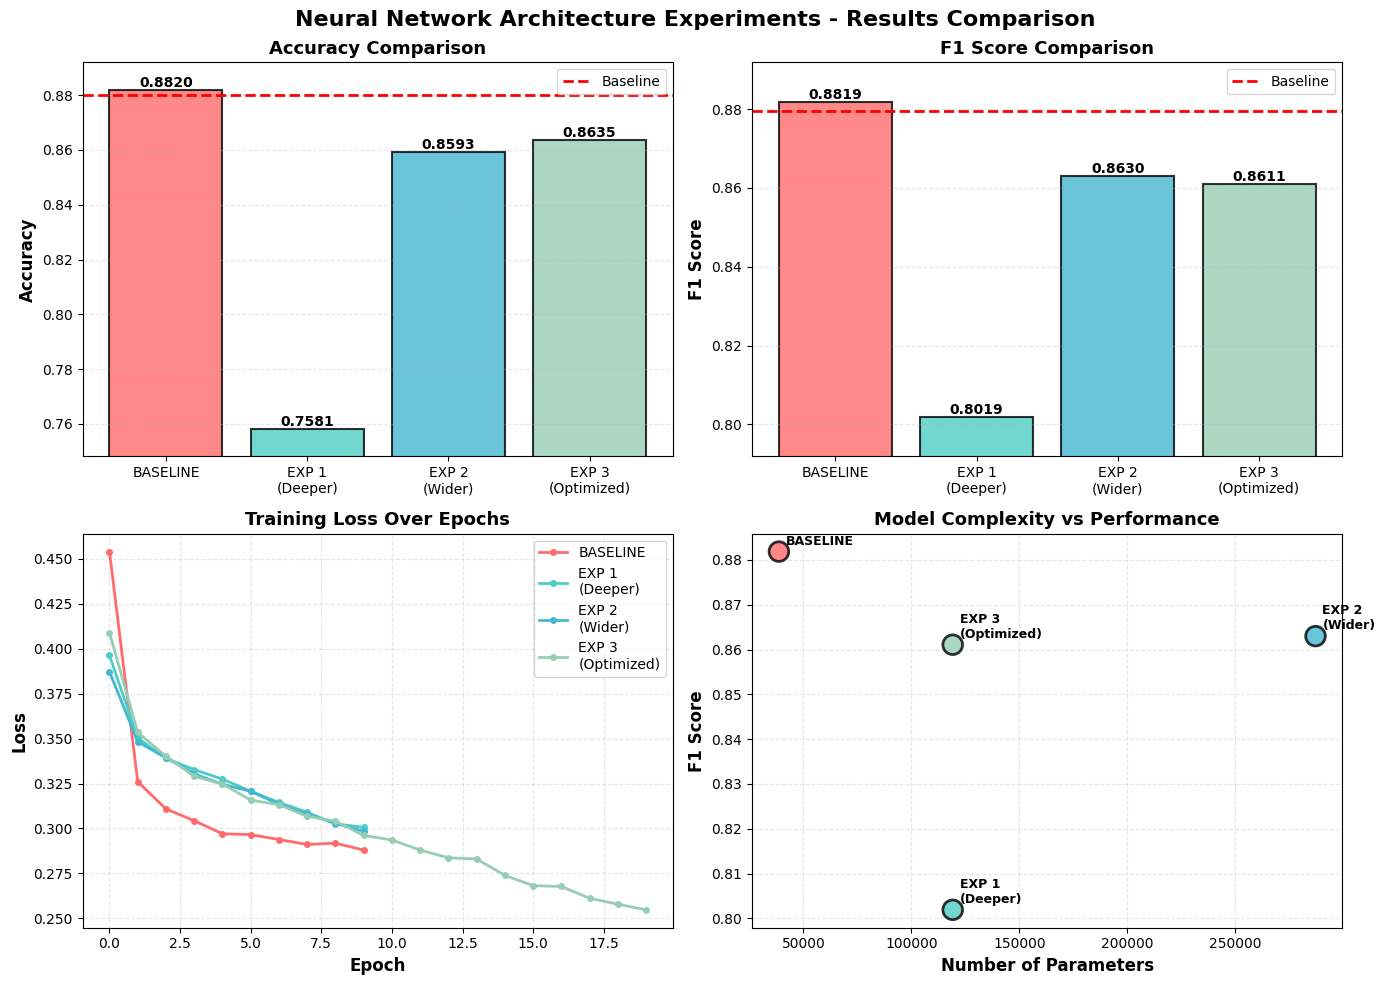

In [34]:
# ============================================================================
# VISUALIZATION

import matplotlib.pyplot as plt
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Neural Network Architecture Experiments - Results Comparison', 
             fontsize=16, fontweight='bold')

names = ['BASELINE', 'EXP 1\n(Deeper)', 'EXP 2\n(Wider)', 'EXP 3\n(Optimized)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# Plot 1: Accuracy Comparison
ax = axes[0, 0]
accuracies = [r['accuracy'] for r in results]
bars = ax.bar(names, accuracies, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
ax.set_ylim([min(accuracies) - 0.01, max(accuracies) + 0.01])
ax.axhline(y=baseline['accuracy'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend()

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: F1 Score Comparison
ax = axes[0, 1]
f1_scores = [r['f1'] for r in results]
bars = ax.bar(names, f1_scores, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('F1 Score Comparison', fontsize=13, fontweight='bold')
ax.set_ylim([min(f1_scores) - 0.01, max(f1_scores) + 0.01])
ax.axhline(y=baseline['f1'], color='red', linestyle='--', linewidth=2, label='Baseline')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend()

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Training Loss Curves
ax = axes[1, 0]
for i, r in enumerate(results):
    ax.plot(r['losses'], label=names[i], marker='o', linewidth=2, 
            markersize=4, color=colors[i])
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Training Loss Over Epochs', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, linestyle='--')

# Plot 4: Model Complexity vs Performance
ax = axes[1, 1]
params = [r['params'] for r in results]
scatter = ax.scatter(params, f1_scores, s=200, c=colors, edgecolor='black', 
                     linewidth=2, alpha=0.8, zorder=3)
ax.set_xlabel('Number of Parameters', fontsize=12, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_title('Model Complexity vs Performance', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')

# Add labels for each point
for i, (x, y) in enumerate(zip(params, f1_scores)):
    ax.annotate(names[i], (x, y), xytext=(5, 5), textcoords='offset points',
                fontweight='bold', fontsize=9)

plt.tight_layout()


# ============================================================================
# KEY TAKEAWAYS
# ============================================================================
print("\n" + "="*80)
print("KEY TAKEAWAYS FOR YOUR REPORT")
print("="*80)
